<a href="https://colab.research.google.com/github/sugarhy/roBERTa-Sentiment-Analysis/blob/main/Sentiment_Analysis_with_roBERTa_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdution**
In this notebook we will be carrying out sentiment analysis on food reviews left by customers on Amazon.com. We will be working with approximately 10,000 reviews and score their positivity, neutrality and negativity scores to identify the overall sentiment of each review.

We will be applying 2 different models - NLTK's VADER and HuggingFace's roBERTa model and comparing the results between the 2 to prove the high performance of Transformers.

# **1. Import necessary libraries and load dataset**

In [23]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('popular')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Do

True

In [3]:
# read in data
# source: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/code
df = pd.read_csv('./Reviews.csv')

In [4]:
# first 5 rows
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
# first review
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [46]:
# data dimensions
print(df.shape)

(27783, 10)


In [47]:
df= df.head(10000)
print(df.shape)

(10000, 10)


# **2. EDA**
We will only be carrying out simple EDA as we will be focusing more on the sentiment analysis model for this project.

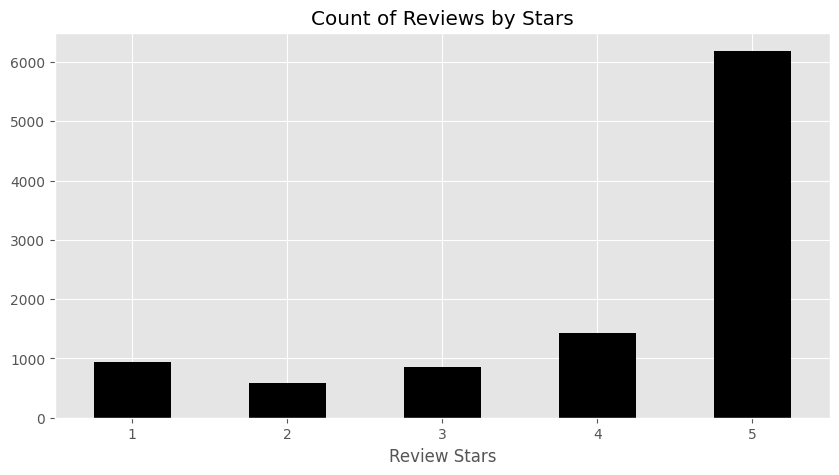

In [48]:
# count reviews by star
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                             title='Count of Reviews by Stars',
                                             figsize=(10,5), color='black')
ax.set_xlabel('Review Stars')
plt.xticks(rotation=0) #rotate x axis labels
plt.show()

### **NLTK**

In [49]:
# 50th review
example= df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


**Tokenize**

In [50]:
# split sent into words
tokens = nltk.word_tokenize(example)

# list the first 10 tokens in the example
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

**POS Tagging**

In [51]:
# run POS Tagging for each token
tagged = nltk.pos_tag(tokens)

# show POS tags for first 10 tokens
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

**Entity Chunking**

In [52]:
# takes tokens and groups into chunks of text
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint() #pretty print

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# **3. Sentimental Analysis Models**
a. VADER (Valence Aware Dictionary and sEntiment Reasoner) <br>
b. roBERTa (transformer)




### **3a.VADER**
- bag-of-words approach:
  - score each text
  - sum up scores of each text
- does not account for the relationship between the words

**Stop word removal**

In [53]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm #progress bar chart

sia= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
# sia on random custom example text
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [55]:
# sia on random custom example text
sia.polarity_scores('I am crying tears of joy')

{'neg': 0.463, 'neu': 0.185, 'pos': 0.352, 'compound': -0.0516}

**Score each text**

In [56]:
# find polarity scores of entire dataset
res= {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
# store dictionary of polarity scores into a dataframe
vaders = pd.DataFrame(res).T #transpose to orient
# rename index as Id
vaders = vaders.reset_index().rename(columns={'index':'Id'})
# merge this onto OG dataframe
vaders = vaders.merge(df, how='left')

**New dataframe contains sentiment score and metadata**



In [58]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**Plot VADER Results**

Text(0.5, 1.0, 'Compound Score by Amazon Star Ratings')

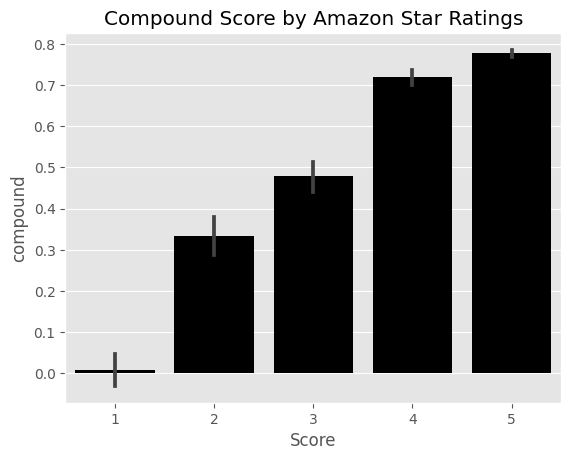

In [59]:
ax= sns.barplot(data=vaders, x='Score', y='compound', color='black')
ax.set_title('Compound Score by Amazon Star Ratings')

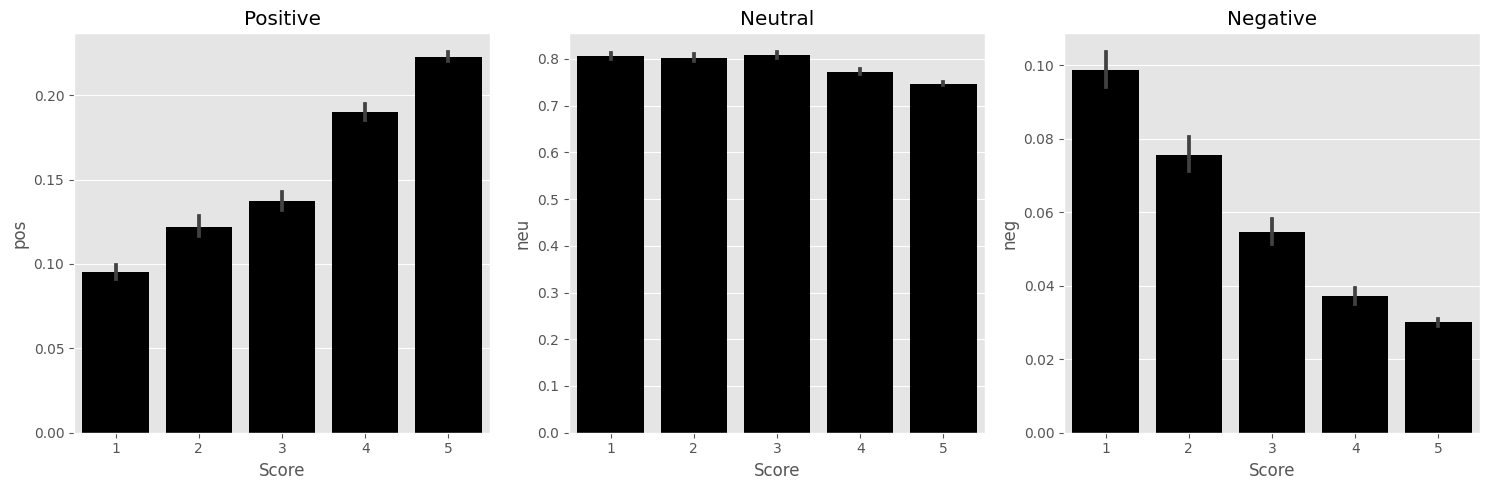

In [60]:
# Stars for each sentiment type
fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], color='black')
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], color='black')
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], color='black')
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

- Graphs show that positivity is higher as the scores (stars rated) gets higher
- Neutral scores are relatively similar throughout the ratings
- Negativity drops (becomes less negative of a comment) as the scores increase

This shows that the sentiment scores haev direct correlation to the actual scores of the reviews (stars)

**3b. roBERTa Pretrained Model**
- deep learning transformer model
- uses a model trained on a large corpus of data
- accounts for the words but also the context related to the words

In [61]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [62]:
# model trained from twitter data
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

**Apply sentiment analysis on an example sentence**

In [64]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [65]:
# roBERTa results on example

# encoding text
encoded_text = tokenizer(example, return_tensors='pt') #taking the example text and putting that into 1s and 0s (embeddings) that the model will understand
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict ={
    'roBERTa_neg': scores[0],
    'roBERTa_neu': scores[1],
    'roBERTa_pos': scores[2]
}
print(scores_dict)

{'roBERTa_neg': 0.97635514, 'roBERTa_neu': 0.020687476, 'roBERTa_pos': 0.002957372}


The roBERTa model outputs a much higher negative sentimental score of 0.976 than the VADER model which outputs a sentimental score of 0.22 for the same example sentence. The sentence is indeed a very negative review. This proves that the roBERTa model is much more accurate and powerful than the VADER model.

**Apply sentiment analysis on the entire dataset**

In [66]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt', truncation=True, max_length=512) #taking the example text and putting that into 1s and 0s (embeddings) that the model will understand
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict ={
      'roBERTa_neg': scores[0],
      'roBERTa_neu': scores[1],
      'roBERTa_pos': scores[2]
  }
  return scores_dict

In [67]:
# find polarity scores of entire dataset
res= {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
      text = row['Text']
      myid = row['Id']
      vader_result = sia.polarity_scores(text)
      # renaming the sentiments in VADER
      vader_result_rename = {}
      for key, value in vader_result.items():
        vader_result_rename[f'vader_{key}'] = value
      roberta_result = polarity_scores_roberta(text)
      both_results = {**vader_result, **roberta_result}
      res[myid] = both_results
  except RuntimeError:
      print(f'Broke for id {myid}')


  0%|          | 0/10000 [00:00<?, ?it/s]

In [68]:
# store dictionary of polarity scores into a dataframe
res_df = pd.DataFrame(res).T #transpose to orient
# rename index as Id
res_df = res_df.reset_index().rename(columns={'index':'Id'})
# merge this onto OG dataframe
res_df = res_df.merge(df, how='left')

In [69]:
res_df.head()

,Id,neg,neu,pos,compound,roBERTa_neg,roBERTa_neu,roBERTa_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# **VADER vs. roBERTa**

In [71]:
res_df.columns

Index(['Id', 'neg', 'neu', 'pos', 'compound', 'roBERTa_neg', 'roBERTa_neu',
       'roBERTa_pos', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

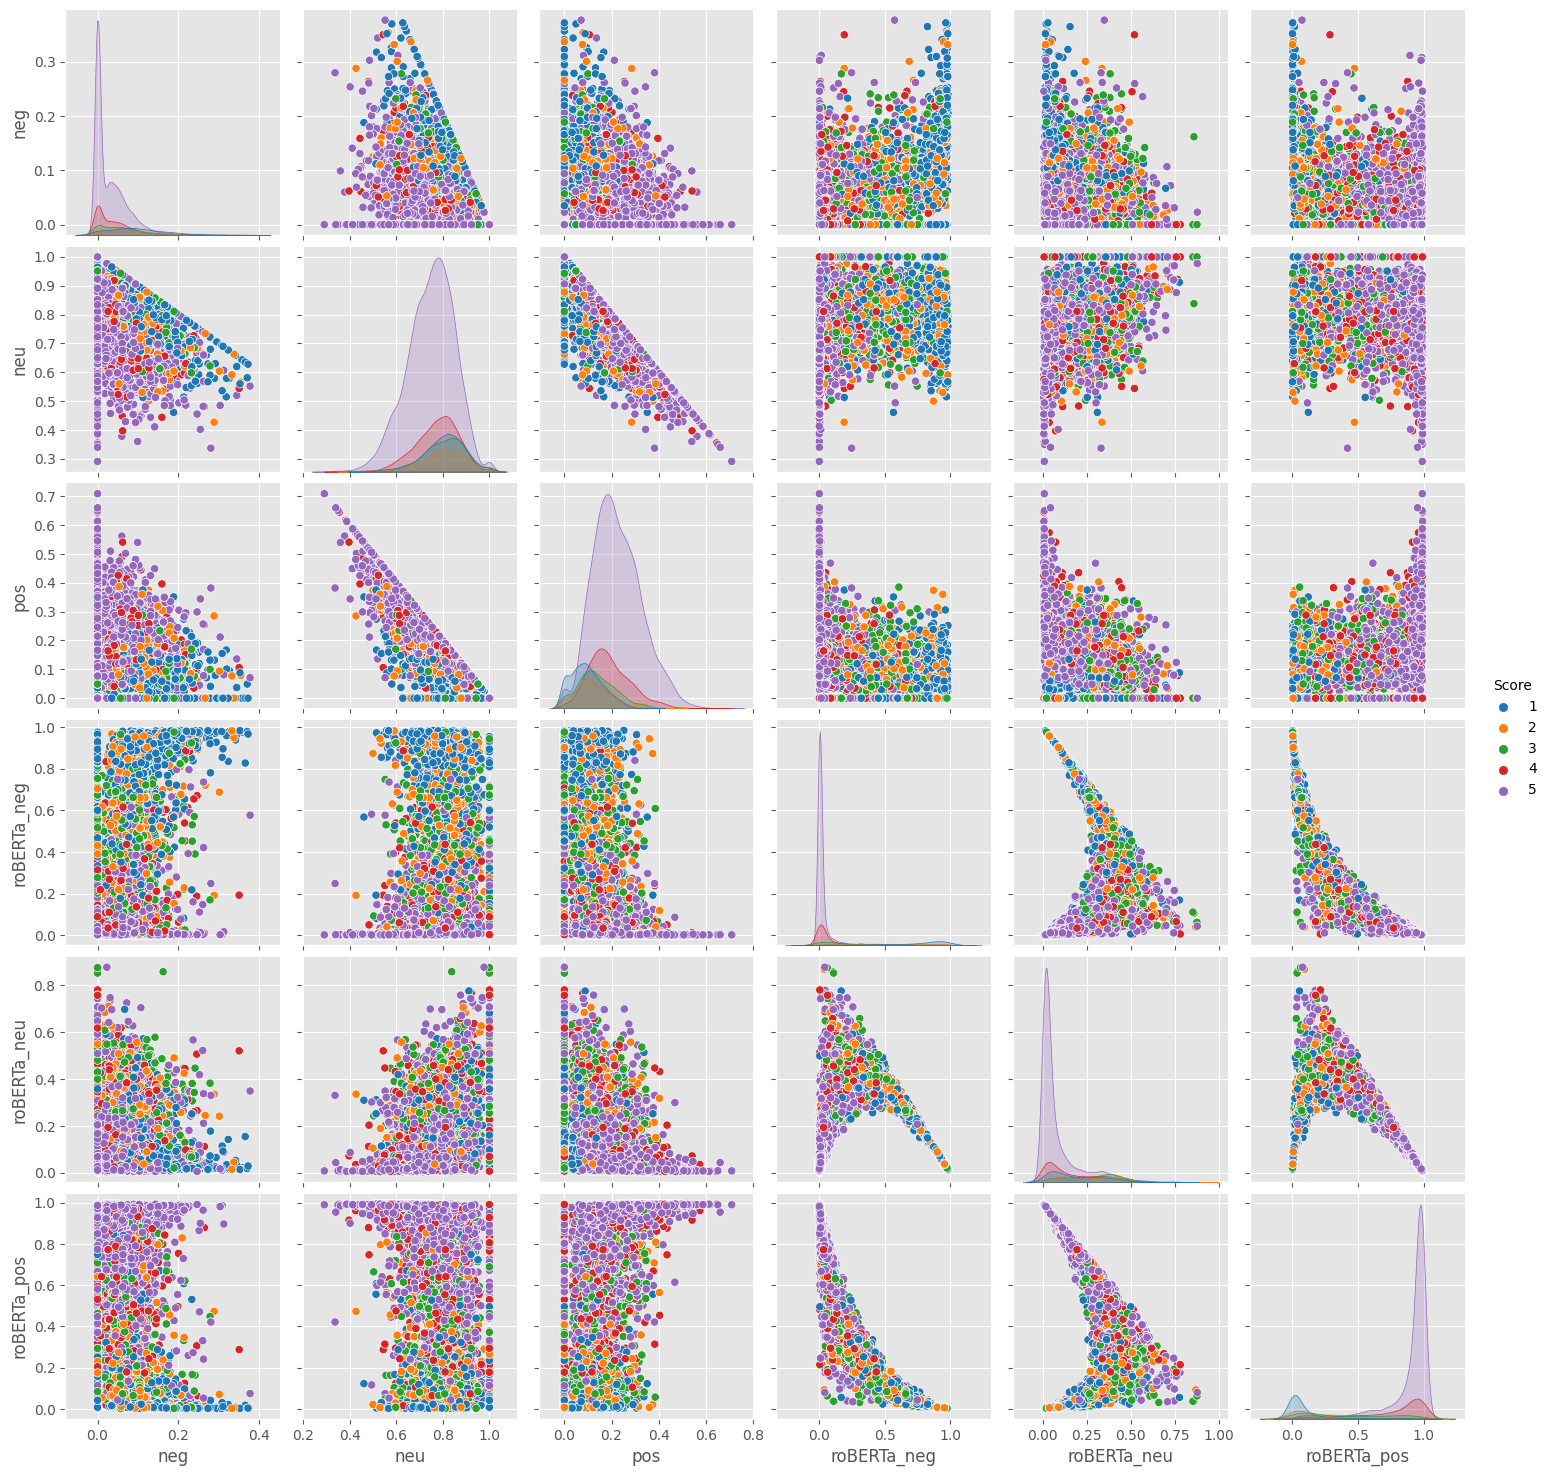

In [72]:
sns.pairplot(data=res_df,
             vars=['neg', 'neu', 'pos',
                  'roBERTa_neg', 'roBERTa_neu', 'roBERTa_pos'],
                  hue='Score',
                  palette='tab10')
plt.show()

The positive sentiment score for the five score/star reviews for the roBERTA model leans significantly to the right of the graph while that for the Vader models leans to the extreme left.

The roBERTa model separates the positive, neutral and negative scores for each of the predictive values much clearly than the Vader model.

These observations from the pairplots prove to us that the roBERTa model is much more confident in predicting the sentiments accurately than the VADER model.

# **REVIEWing**

### **Review a bad review with the highest positive score**

In [74]:
# VADER: output the review with the most positive score for a 1 star rating (bad review)
res_df.query('Score == 1')\
.sort_values('pos', ascending=False)['Text'].values[0]

'This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!'

In [75]:
# roBERTa: output the review with the most positive score for a 1 star rating (bad review)
res_df.query('Score == 1')\
.sort_values('roBERTa_pos', ascending=False)['Text'].values[0]

'Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram'

### **Review a good review with the highest negative score**

In [76]:
# VADER: output the review with the most negative score for a 5 star rating (good review)
res_df.query('Score == 5')\
.sort_values('neg', ascending=False)['Text'].values[0]

'My two cats must not be interested in grass, because it grew but they ignored it. Had no problems growing it.'

In [77]:
# roBERTa: output the review with the most negative score for a 5 star rating (good review)
res_df.query('Score == 5')\
.sort_values('roBERTa_neg', ascending=False)['Text'].values[0]

'They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')